In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy import interpolate
%matplotlib inline

In [63]:

filedir = "data/Rb.xlsx"
file = pd.ExcelFile(filedir)
sheet_names=file.sheet_names

In [64]:
all_loads = []
all_pos = []
buf = 5
for i, name in enumerate(sheet_names):
    data= pd.read_excel(filedir,sheet_name=name)
    pos = np.array([float(i) for i in data.loc[:,"POSITION"]])
    load = np.array([float(i) for i in data.loc[:,"LOADCELL"]])
    irup = np.argmax(load)
    all_loads.append(load[buf:irup])
    all_pos.append(pos[buf:irup])

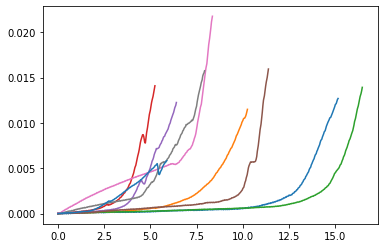

In [65]:
fig,axs = plt.subplots()
for position,load in zip(all_pos,all_loads):
    plt.plot(position,load)
plt.show()

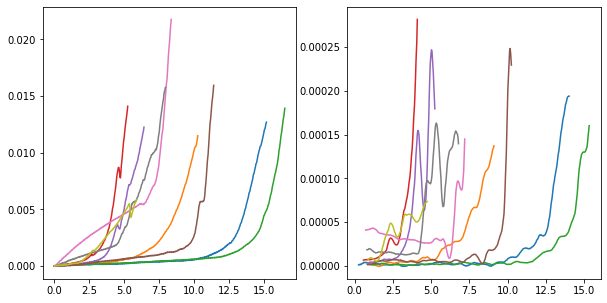

In [68]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
window = 31
for position,load in zip(all_pos,all_loads):
    if(len(load)>window):
        deriv = savgol_filter(load,window,3,1)
        axs[0].plot(position,load)
        axs[1].plot(position[window:-window],deriv[window:-window])
plt.show()

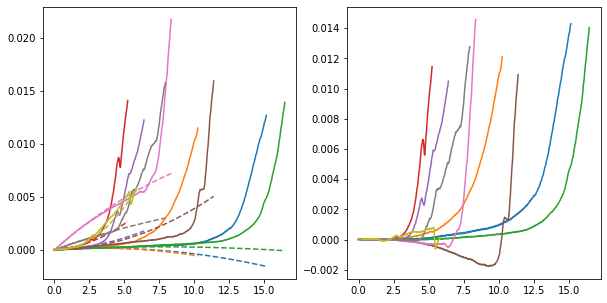

In [69]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
xnew=[]
ynew=[]
jnew=[]
j=0
for position,load in zip(all_pos,all_loads):
    if(len(load)>window):
        jnew.append(j)
        ipoint = np.argmin((position-2.5)**2)
        x,y=position[:ipoint],load[:ipoint]
        poly = np.polyfit(x, y, 2)
        lines = axs[0].plot(position,load)
        axs[0].plot(position,np.polyval(poly,position),'--',color=lines[0].get_color())
        axs[1].plot(position,load-np.polyval(poly,position))
        xnew.append(position)
        ynew.append(load-np.polyval(poly,position))
    j+=1
plt.show()

In [70]:
def find_CP(x,y,zerorange=900):
    """Finds the CP from F-Z curves by auto-thresholding data. 
    Algorithm writteb by Prof Massimo Vassalli and avilable
    at the open source repository: https://github.com/CellMechLab/softmech"""
    deg = 0 
    worky = np.copy(y)
    xtarget = np.min(x) + zerorange *1e-3
    jtarget = np.argmin( np.abs(x-xtarget) )

    #which direction?
    if x[0]<x[-1]:
        xlin = x[:jtarget]
        ylin = worky[:jtarget]
        m,q = np.polyfit(xlin,ylin,1)
    else:
        xlin = x[jtarget:]
        ylin = worky[jtarget:]
        m,q = np.polyfit(xlin,ylin,1)

    worky = worky-m*x-q

    differences = (worky[1:]+worky[:-1])/2
    midpoints = np.array(list(set(differences)))
    midpoints.sort()

    crossings = []
    for threshold in midpoints[midpoints>0]:
        crossings.append( np.sum( np.bitwise_and( (worky[1:]>threshold),(worky[:-1]<threshold) )))
    crossings=np.array(crossings)

    inflection = midpoints[midpoints>0][np.where(crossings==1)[0][0]]
    jcpguess = np.argmin( np.abs(differences-inflection) )+1

    xcp = x[jcpguess]
    ycp = y[jcpguess]
    return [xcp, ycp]

def average_curve(arrs):
    """Finds the average array from a list of arrays containing 
    arrays of different lengths."""
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

def linear(x, m, q):
    return m*x+q

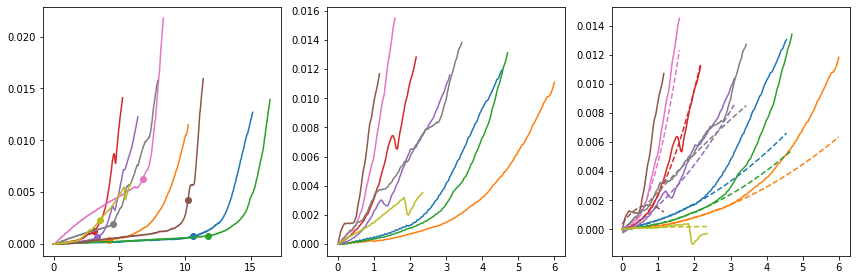

In [71]:
fig,axs = plt.subplots(1,3,figsize=(12,4))
maxlaod = []
for x,y,j in zip(xnew,ynew,jnew):
    position=all_pos[j]
    load=all_loads[j]
    l=axs[0].plot(position,load)
    x0,y0=find_CP(x,y,3000)
    icp = np.argmin((x-x0)**2)
    axs[0].plot([position[icp]],[load[icp]],'o',color=l[0].get_color())
    #this is the data of interest 
    xgood  =  position[icp:]-x0
    ygood = load[icp:]-load[icp]
    axs[1].plot(xgood,ygood)
    maxlaod.append(max(ygood)*1000.0) #in mN
    xx,yy=x[icp:]-x0,y[icp:]-y[icp]
    l=axs[2].plot(xx,yy)
    jmax = int(len(xx)/2)
    poly = np.polyfit(xx[:jmax], yy[:jmax], 2)
    l=axs[2].plot(xx,np.polyval(poly,xx),'--',color=l[0].get_color())
fig.tight_layout()
plt.show()
#save max load in an excel file inside the data folder in the results folder with the name of the original file
maxlaod = pd.DataFrame(maxlaod)
maxlaod.to_excel("data/results/"+filedir.split("/")[-1].split(".")[0]+"_maxload.xlsx")


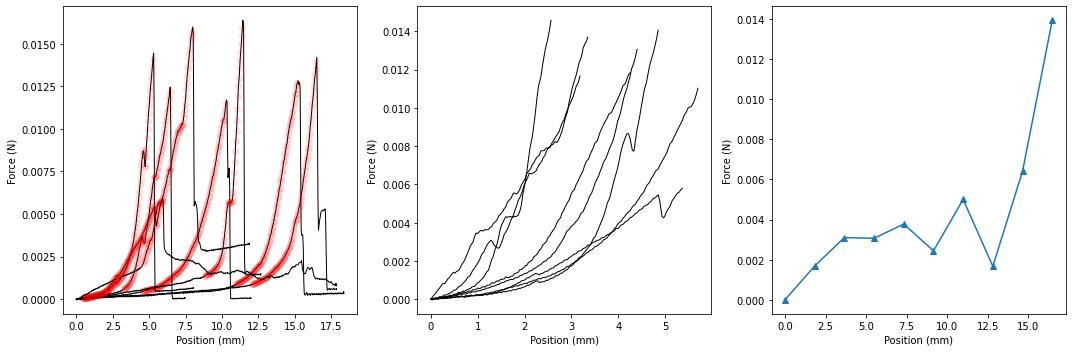

In [57]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
for i, name in enumerate(sheet_names):
    data= pd.read_excel(filedir,sheet_name=name)
    pos = np.array([float(i) for i in data.loc[:,"POSITION"]])
    load = np.array([float(i) for i in data.loc[:,"LOADCELL"]])
    x0,y0 = find_CP(pos,load,zerorange=3000)
    x0ind = np.argmin((pos-x0)**2)
    y0ind = np.argmin((load-y0)**2)
    rupture = max(load)
    irupture = np.argmin((load-rupture)**2)
    if rupture<0.02: #avoid bad curves
        axs[0].plot(pos,load,color='black',lw=1)
        axs[0].plot(pos[y0ind:irupture],load[y0ind:irupture],'o',color='red',alpha=0.1)
        #align curves to the same origin
        pos = pos - x0
        load = load - y0
        axs[1].plot(pos[y0ind:irupture],load[y0ind:irupture],color='black',lw=1)
        all_loads.append(load[y0ind:irupture])
        all_pos.append(pos[y0ind:irupture])
#average curves
avg_force,avg_force_std = average_curve(all_loads)
avg_pos,avg_pos_std = average_curve(all_pos)
f = interpolate.interp1d(avg_pos,avg_force,kind='cubic')
x_interp = np.linspace(np.min(avg_pos),np.max(avg_pos),10)
y_interp = f(x_interp)
axs[2].plot(x_interp,y_interp,'-^',label='interpolated average')
for ax in axs:
    ax.set_xlabel("Position (mm)")
    ax.set_ylabel("Force (N)")
fig.tight_layout()
plt.show()

In [18]:
popt, pcov = curve_fit(linear, x_interp[0:10], y_interp[0:10])
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(x_interp,y_interp,'o',label='interpolated average')
ax.plot(x_interp,linear(x_interp,*popt),label='linear fit')
print(popt)

[ 0.00150972 -0.00096885]


In [ ]:
#Save interpolated data for plotting comparison
